# Magnetotelluric at Yulong Mountain
### Name: 
### Student ID: 

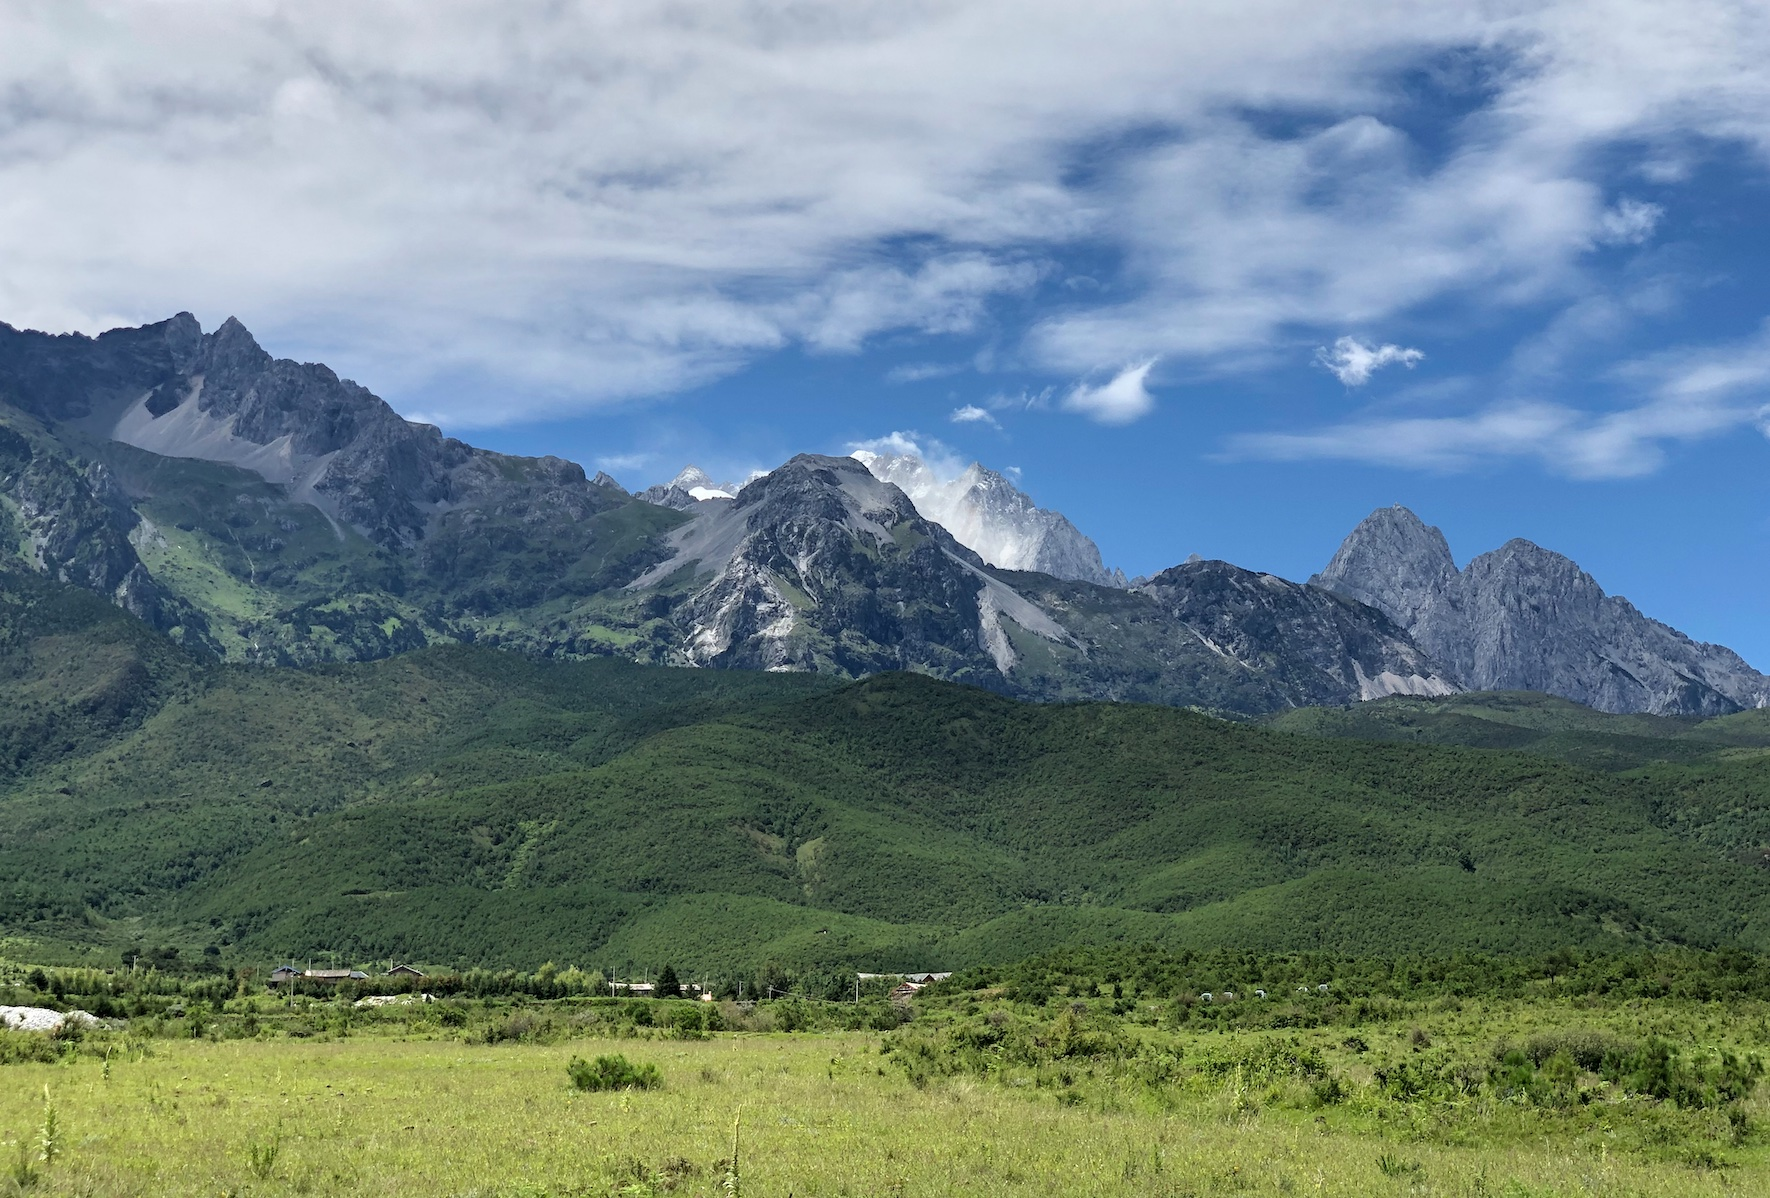

## 1. Setup

The Yulong Mountain in Lijiang, Yunnan is famous as a tourism attraction. The area is also of great significance in the study of geodynamics and the associated geohazard, particularly earthquakes. The geophysics department of SUSTech is planning to establish a field observatory in that area for the long-term monitoring. The department has sent out a group of students to Yulong Mountain to carry out some geophysical surveys for the selection of site.

There are some considerations for the selection of site:
1. Must be at geologically stable places away from landslides or floods.
2. Must be over some significant geological units, for example, faults or other complex structures.
3. Must be sufficiently away from cultural noises.

The department has preliminarily chosen four locations as the candidates. They would like to first carry out a low-cost investigation at the sites to answer some basic questions:

1. How complex is the geology near the sites?
2. What is the thickness of the overburden? 
3. Are there any noises from the tourism facilities nearby?


---
## 2. Properties

Geophysical methods only work if there is a contrast in physical properties. In this site selection project, the geological units in the area include basement or outcropped igneous rocks, overbruden, faulted or fractured zones, and water-saturated sedimentary rocks. 

### Questions:
Find the approximate physical properties (or ranges) for the geological units that you may encounter in this project. Also provide comments on whether these properties can be practically used to locate and identify underwater treasures.

### Your answers:
|  Material          |            Density  | Susceptibility (magnetic permeability)  | Electrical conductivity   |
|--------------------|---------------------|-----------------------------------------|---------------------------|
| Igneous rocks      |                     |                                         |                           |   
| Sedimentary rocks  |                     |                                         |                           |   
| Overburnden        |                     |                                         |                           |  
| Fractured zones    |                     |                                         |                           |    

- Comments:

---
## 3. Survey

The magnetotelluric (MT) method is a widely used EM exploration method and its depth of penetration can be from tens of meters to hundreds of kilometers, depdending on the frequency of observed signals. The sources in MT come from lightning strikes and interactions of the solar wind with the earth's magnetic field. EM waves, regardless of the angle of incidence, hit the ground surface and get refracted vertically, because of the extreme contrast in
conductivity. As a result, the physical model of an MT source is a vertically propagating plane wave. In this exercise, a 1D layered earth model is assumed.

Measurements in an MT survey are typically the time series of two orthogonal electric fields **Ex** and **Ey**, and three magnetic fields **Hx**, **Hy** and **Hz**. The time series are then FFT-transformed to the frequency domain at discrete frequencies. Because the natural field is random and unknown, we take the ratio of the electric and magnetic fields, called the impedance, as MT data that only reflect the conductivity structure below and around the MT station.


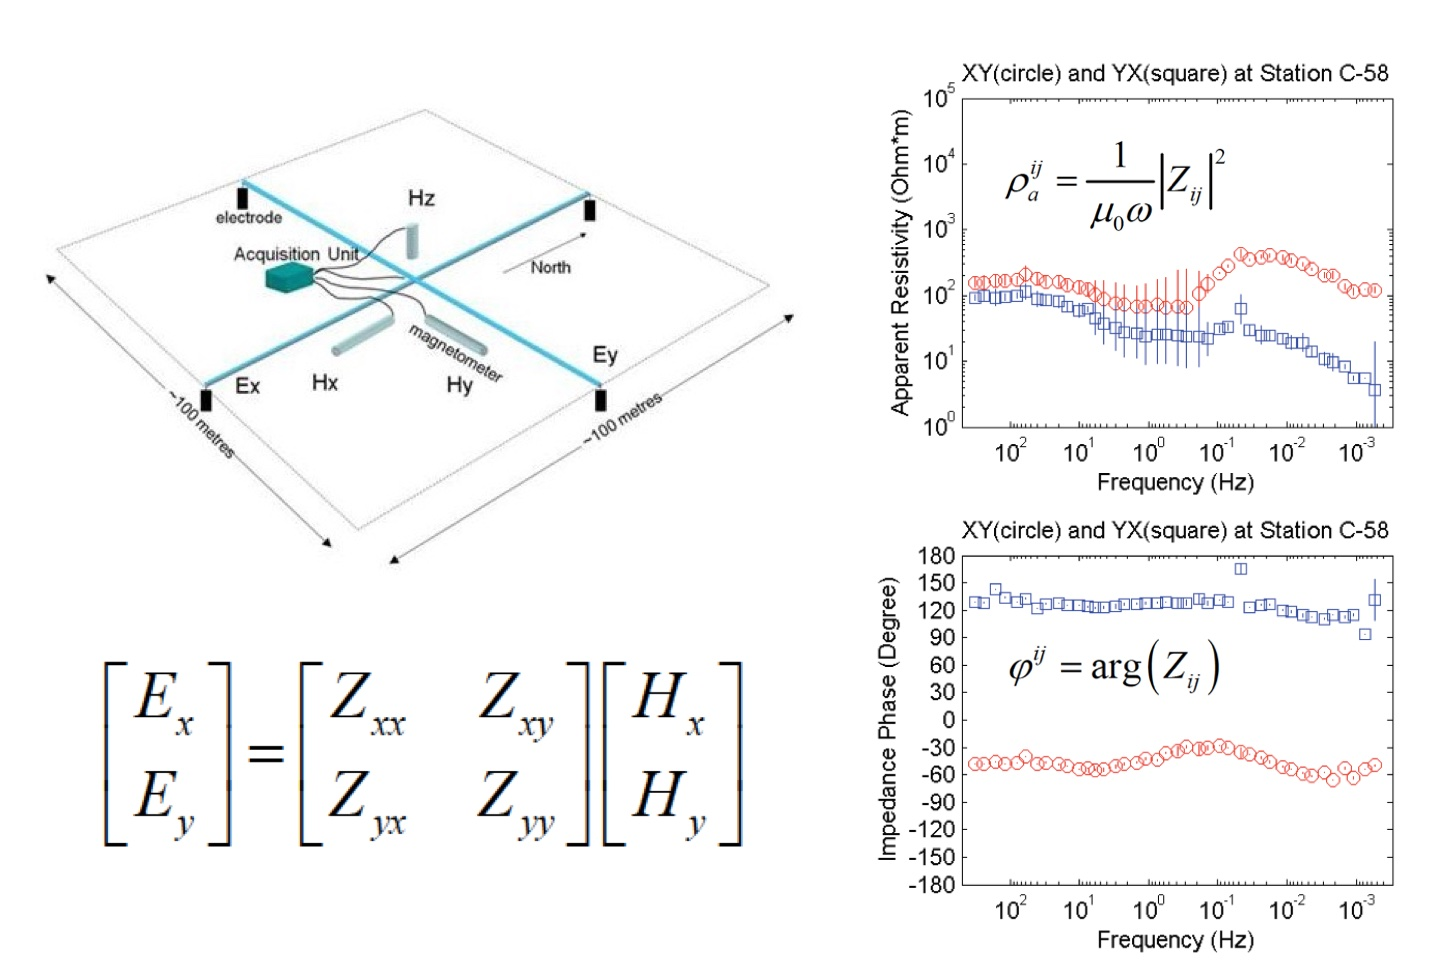

---
## 4. Data

MT data are complex impedance tensors at some frequencies. A common practice is to convert the impedance data to apparent resistivities and phase angles. Because the frequency can be related to the depth, a plot of frequency-versus-apparent resistivity can be a convenient tool for a qualitative analysis.

The dimensionality of the earth structure can be inferred from the impedance tensor:
- 1D: **Zxx = Zyy = 0** and **Zxy = Zyx ≠ 0**
- 2D: **Zxx = Zyy = 0** and **Zxy ≠ Zyx ≠ 0**
- 3D: **Zxx ≠ Zyy ≠ Zxy ≠ Zyx ≠ 0**

The following code (Astic, 2016) carries out a MT simulation for a 1D earth model.

In [26]:
from scipy.constants import epsilon_0, mu_0
import matplotlib.pyplot as plt
import numpy as np
import imageio

"""
MT1D: n layered earth problem
*****************************

Author: Thibaut Astic
Contact: thast@eos.ubc.ca
Date: January 2016

This code compute the analytic response of a n-layered Earth to a plane wave (Magneto-Tellurics).

We start by looking at Maxwell's equations in the electric
field \\\(\\\mathbf{E}\\) and the magnetic flux
\\\(\\\mathbf{H}\\) to write the wave equations
\\(\\ \nabla ^2  \mathbf{E_x} + k^2 \mathbf{E_x} = 0 \\) &
\\(\\ \nabla ^2  \mathbf{H_y} + k^2 \mathbf{H_y} = 0 \\)

Then solving the equations in each layer "j" between z_{j-1} and z_j in the form of
\\(\\ E_{x,j} (z) = U_j e^{i k (z-z_{j-1})} + D_j e^{-i k (z-z_{j-1})} \\)
\\(\\ H_{y,j} (z) = \frac{1}{Z_j} (D_j e^{-i k (z-z_{j-1})} - U_j e^{i k (z-z_{j-1})}) \\)

With U and D the Up and Down components of the E-field.

The iteration from one layer to another is ensure by:

\\(\\  \left(\begin{matrix} E_{x,j} \\ H_{y,j} \end{matrix} \right) =
    P_j T_j P^{-1}_J \left(\begin{matrix} E_{x,j+1} \\ H_{y,j+1} \end{matrix} \right) \\)

And the Boundary Condition is set for the E-field in the last layer, with no Up component (=0)
and only a down component (=1 then normalized by the highest amplitude to ensure numeric stability)

The layer 0 is assumed to be the air layer.

"""

#Frequency conversion
omega = lambda f: 2.*np.pi*f

#Evaluate k wavenumber
k = lambda f,sig,mu,eps: np.sqrt(mu*mu_0*eps*epsilon_0*(2.*np.pi*f)**2.-1.j*mu*mu_0*sig*omega(f))


#Define a frquency range for a survey
frange = lambda minfreq, maxfreq, step: np.logspace(minfreq,maxfreq,num = step, base = 10.)

#Functions to create random physical Perties for a n-layered earth
thick = lambda minthick, maxthick, nlayer: np.append(np.array([1.2*10.**5]),
                                                     np.ndarray.round(minthick + (maxthick-minthick)* np.random.rand(nlayer-1,1)
                                                            ,decimals =1))

sig = lambda minsig, maxsig, nlayer: np.append(np.array([0.]),
                                               np.ndarray.round(10.**minsig + (10.**maxsig-10.**minsig)* np.random.rand(nlayer,1)
                                                      ,decimals=3))

mu  = lambda minmu, maxmu, nlayer: np.append(np.array([1.]),
                                             np.ndarray.round(minmu + (maxmu-minmu)* np.random.rand(nlayer,1)
                                                    ,decimals=1))

eps = lambda mineps, maxeps, nlayer: np.append(np.array([1.]),
                                               np.ndarray.round(mineps + (maxeps-mineps)* np.random.rand(nlayer,1)
                                                                ,decimals=1))

#Evaluate Impedance Z of a layer
ImpZ = lambda f, mu, k: omega(f)*mu*mu_0/k

#Complex Cole-Cole Conductivity - EM utils
PCC= lambda siginf,m,t,c,f: siginf*(1.-(m/(1.+(1j*omega(f)*t)**c)))

#Converted thickness array into top of layer array
def top(thick):
    topv= np.zeros(len(thick)+1)
    
    topv[0]=-thick[0]

    for i in range(1,len(topv),1):
        topv[i] = topv[i-1] + thick[i-1]
    
    return topv

#Propagation Matrix and theirs inverses

#matrix T for transition of Up and Down components accross a layer
T = lambda h,k: np.matrix([[np.exp(1j*k*h),0.],[0.,np.exp(-1j*k*h)]],dtype='complex_')

Tinv = lambda h,k: np.matrix([[np.exp(-1j*k*h),0.],[0.,np.exp(1j*k*h)]],dtype='complex_')

#transition of Up and Down components accross a layer
UD_Z = lambda UD,z,zj,k : T((z-zj),k)*UD


#matrix P relating Up and Down components with E and H fields
P = lambda z: np.matrix([[1.,1,],[-1./z,1./z]],dtype='complex_')

Pinv = lambda z: np.matrix([[1.,-z],[1.,z]],dtype='complex_')/2.


#Time Variation of E and H
E_ZT = lambda U,D,f,t : np.exp(1j*omega(f)*t)*(U+D)
H_ZT = lambda U,D,Z,f,t : (1./Z)*np.exp(1j*omega(f)*t)*(D-U)

#Plot the configuration of the problem
def PlotConfiguration(thick,sig,eps,mu,ax,widthg,z):

    topn = top(thick)
    widthn = np.arange(-widthg,widthg+widthg/10.,widthg/10.)

    ax.set_ylim([z.min(),z.max()])
    ax.set_xlim([-widthg,widthg])

    ax.set_ylabel("Depth (m)", fontsize=16.)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    #define filling for the different layers
    hatches=['/'  , '+', 'x', '|' , '\\', '-'  , 'o' , 'O' , '.' , '*' ]

    #Write the physical properties of air
    ax.annotate(("Air, $\sigma$ =%1.0f mS/m")%(sig[0]*10**(3)),
            xy=(-widthg/2., -np.abs(z.max())/2.), xycoords='data',
            xytext=(-widthg/2., -np.abs(z.max())/2.), textcoords='data',
            fontsize=14.)

    ax.annotate(("$\epsilon_r$= %1i")%(eps[0]),
            xy=(-widthg/2., -np.abs(z.max())/3.), xycoords='data',
            xytext=(-widthg/2., -np.abs(z.max())/3.), textcoords='data',
            fontsize=14.)

    ax.annotate(("$\mu_r$= %1i")%(mu[0]),
            xy=(-widthg/2., -np.abs(z.max())/3.), xycoords='data',
            xytext=(0, -np.abs(z.max())/3.), textcoords='data',
            fontsize=14.)

    #Write the physical properties of the differents layers up to the (n-1)-th and fill it with pattern
    for i in range(1,len(topn)-1,1):
        if topn[i] == topn[i+1]:
            pass
        else:
            ax.annotate(("$\sigma$ =%3.3f mS/m")%(sig[i]*10**(3)),
                xy=(0., (2.*topn[i]+topn[i+1])/3), xycoords='data',
                xytext=(0., (2.*topn[i]+topn[i+1])/3), textcoords='data',
                fontsize=14.)

            ax.annotate(("$\epsilon_r$= %1i")%(eps[i]),
                xy=(-widthg/1.1, (2.*topn[i]+topn[i+1])/3), xycoords='data',
                xytext=(-widthg/1.1, (2.*topn[i]+topn[i+1])/3), textcoords='data',
                fontsize=14.)

            ax.annotate(("$\mu_r$= %1.2f")%(mu[i]),
                xy=(-widthg/2., (2.*topn[i]+topn[i+1])/3), xycoords='data',
                xytext=(-widthg/2., (2.*topn[i]+topn[i+1])/3), textcoords='data',
                fontsize=14.)

            ax.plot(widthn,topn[i]*np.ones_like(widthn),color='black')
            ax.fill_between(widthn,topn[i],topn[i+1],alpha=0.3,color="none",edgecolor='black', hatch=hatches[(i-1)%10])

    #Write the physical properties of the n-th layer and fill it with pattern
    ax.plot(widthn,topn[-1]*np.ones_like(widthn),color='black')
    ax.fill_between(widthn,topn[-1],z.max(),alpha=0.3,color="none",edgecolor='black', hatch=hatches[(len(topn)-2)%10])

    ax.annotate(("$\sigma$ =%3.3f mS/m")%(sig[-1]*10**(3)),
            xy=(0., (2.*topn[-1]+z.max())/3), xycoords='data',
            xytext=(0., (2.*topn[-1]+z.max())/3), textcoords='data',
            fontsize=14.)

    ax.annotate(("$\epsilon_r$= %1i")%(eps[-1]),
            xy=(-widthg/1.1, (2.*topn[-1]+z.max())/3), xycoords='data',
            xytext=(-widthg/1.1, (2.*topn[-1]+z.max())/3), textcoords='data',
            fontsize=14.)

    ax.annotate(("$\mu_r$= %1.2f")%(mu[-1]),
            xy=(-widthg/2., (2.*topn[-1]+z.max())/3), xycoords='data',
            xytext=(-widthg/2., (2.*topn[-1]+z.max())/3), textcoords='data',
            fontsize=14.)

    #plot Trees!
    ax.annotate("",
            xy=(widthg/2., -1.*z.max()/5.), xycoords='data',
            xytext=(widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.2,head_length=0.2',color='green',linewidth=2.)
            )

    ax.annotate("",
            xy=(widthg/2., -3./4.*z.max()/5.), xycoords='data',
            xytext=(widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.4,head_length=0.4',color='green',linewidth=2.)
            )

    ax.annotate("",
            xy=(widthg/2., -1./2.*z.max()/5.), xycoords='data',
            xytext=(widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.6,head_length=0.6',color='green',linewidth=2.)
            )
    
    ax.annotate("",
            xy=(1.2*widthg/2., -1.*z.max()/5.), xycoords='data',
            xytext=(1.2*widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.2,head_length=0.2',color='green',linewidth=2.)
            )

    ax.annotate("",
            xy=(1.2*widthg/2., -3./4.*z.max()/5.), xycoords='data',
            xytext=(1.2*widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.4,head_length=0.4',color='green',linewidth=2.)
            )

    ax.annotate("",
            xy=(1.2*widthg/2., -1./2.*z.max()/5.), xycoords='data',
            xytext=(1.2*widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.6,head_length=0.6',color='green',linewidth=2.)
            )
    
    ax.annotate("",
            xy=(1.5*widthg/2., -1.*z.max()/5.), xycoords='data',
            xytext=(1.5*widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.2,head_length=0.2',color='green',linewidth=2.)
            )

    ax.annotate("",
            xy=(1.5*widthg/2., -3./4.*z.max()/5.), xycoords='data',
            xytext=(1.5*widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.4,head_length=0.4',color='green',linewidth=2.)
            )

    ax.annotate("",
            xy=(1.5*widthg/2., -1./2.*z.max()/5.), xycoords='data',
            xytext=(1.5*widthg/2., 0.), textcoords='data',
            arrowprops=dict(arrowstyle='->, head_width=0.6,head_length=0.6',color='green',linewidth=2.)
            )


    ax.invert_yaxis()

    return ax

#Propagate Up and Down component for a certain frequency & evaluate E and H field

def Propagate(f,H,sig,chg,taux,c,mu,eps,n):

    sigcm = np.zeros_like(sig,dtype='complex_')

    for j in range(1,len(sig)):
        sigcm[j]=PCC(sig[j],chg[j],taux[j],c[j],f)

    K = k(f, sigcm, mu, eps)
    Z = ImpZ(f,mu,K)

    EH = np.matrix(np.zeros((2,n+1),dtype = 'complex_'),dtype = 'complex_')
    UD = np.matrix(np.zeros((2,n+1),dtype = 'complex_'),dtype = 'complex_')

    UD[1,-1] = 1.

    for i in range(-2,-(n+2),-1):

        UD[:,i] = Tinv(H[i+1],K[i])*Pinv(Z[i])*P(Z[i+1])*UD[:,i+1]
        UD = UD/((np.abs(UD[0,:]+UD[1,:])).max())

    for j in range(0,n+1):
        EH[:,j] = np.matrix([[1.,1,],[-1./Z[j],1./Z[j]]])*UD[:,j]

    return UD, EH, Z ,K


#Evaluate the apparent resistivity and phase for a frequency range
def appres(F,H,sig,chg,taux,c,mu,eps,n):

    Res = np.zeros_like(F)
    Phase = np.zeros_like(F)
    App_ImpZ= np.zeros_like(F,dtype='complex_')

    for i in range(0,len(F)):

        UD,EH,Z ,K = Propagate(F[i],H,sig,chg,taux,c,mu,eps,n)

        App_ImpZ[i] = EH[0,1]/EH[1,1]

        Res[i] = np.abs(App_ImpZ[i])**2./(mu_0*omega(F[i]))
        Phase[i] = np.angle(App_ImpZ[i], deg = True)

    return Res,Phase

#Evaluate Up, Down components, E and H field, for a frequency range,
#a discretized depth range and a time range (use to calculate envelope)
def calculateEHzt(F,H,sig,chg,taux,c,mu,eps,n,zsample,tsample):

    topc = top(H)

    layer = np.zeros(len(zsample),dtype=np.int)-1

    Exzt = np.matrix(np.zeros((len(zsample),len(tsample)),dtype = 'complex_'),dtype = 'complex_')
    Hyzt = np.matrix(np.zeros((len(zsample),len(tsample)),dtype = 'complex_'),dtype = 'complex_')
    Uz = np.matrix(np.zeros((len(zsample),len(tsample)),dtype = 'complex_'),dtype = 'complex_')
    Dz = np.matrix(np.zeros((len(zsample),len(tsample)),dtype = 'complex_'),dtype = 'complex_')
    UDaux = np.matrix(np.zeros((2,len(zsample)),dtype = 'complex_'),dtype = 'complex_')

    for i in range(0,n+1,1):
        layer = layer+(zsample>=topc[i])*1

    for j in range(0,len(F)):

        UD,EH,Z ,K = Propagate(F[j],H,sig,chg,taux,c,mu,eps,n)

        for p in range(0,len(zsample)):

            UDaux[:,p] = UD_Z(UD[:,layer[p]],zsample[p],topc[layer[p]],K[layer[p]])

            for q in range(0,len(tsample)):

                Exzt[p,q]  = Exzt[p,q] + E_ZT(UDaux[0,p],UDaux[1,p],F[j],tsample[q])/len(F)
                Hyzt[p,q] = Hyzt[p,q] + H_ZT(UDaux[0,p],UDaux[1,p],Z[layer[p]],F[j],tsample[q])/len(F)
                Uz[p,q] = Uz[p,q] + UDaux[0,p]*np.exp(1j*omega(F[j])*tsample[q])/len(F)
                Dz[p,q] = Dz[p,q] + UDaux[1,p]*np.exp(1j*omega(F[j])*tsample[q])/len(F)

    return  Exzt,Hyzt,Uz,Dz,UDaux,layer


#Function to Plot Apparent Resistivity and Phase
def PlotAppRes(F,H,sig,chg,taux,c,mu,eps,n,fenvelope,PlotEnvelope):

    Res, Phase = appres(F,H,sig,chg,taux,c,mu,eps,n)

    fig,ax = plt.subplots(1,2,figsize=(16,10))

    ax[0].scatter(Res,F,color='black')
    ax[0].set_xscale('Log')
    ax[0].set_yscale('Log')
    ax[0].set_xlim([10.**(np.log10(Res.min())-1.),10.**(np.log10(Res.max())+1.)])
    ax[0].set_ylim([F.min(),F.max()])
    ax[0].set_xlabel('Apparent Resistivity (Ohm*m)',fontsize=16.,color="black")
    ax[0].set_ylabel('Frequency (Hz)',fontsize=16.)
    ax[0].grid(which='major')

    ax0 = ax[0].twiny()

    ax0.set_xlim([0.,90.])
    ax0.set_ylim([F.min(),F.max()])
    ax0.scatter(Phase,F,color='purple')
    ax0.set_xlabel('Phase (Degrees)',fontsize=16.,color="purple")

    zc=np.arange(-(H[1:].max()+10)*n,(H[1:].max()+10)*n,10.)

    ax[0].tick_params(labelsize=16)
    ax[1].tick_params(labelsize=16)
    ax0.tick_params(labelsize=16)

    if PlotEnvelope:

        widthn=np.logspace(np.log10(Res.min())-1., np.log10(Res.max())+1., num=100, endpoint=True, base=10.0)
        fenvelope1n=np.ones(100)*fenvelope
        ax[0].plot(widthn,fenvelope1n,linestyle='dashed',color='black')

        tc=np.arange(0.,1./fenvelope,0.01/(fenvelope))
        Exzt,Hyzt,Uz,Dz,UDaux,layer = calculateEHzt(np.array([fenvelope]),H,sig,chg,taux,c,mu,eps,n,zc,tc)

        ax1=ax[1].twiny()

        ax[1].tick_params(labelsize=16)
        ax1.tick_params(labelsize=16)

        ax[1].set_xlabel('Amplitude Electric Field E (V/m)',color='blue',fontsize=16)

        ax1.set_xlabel('Amplitude Magnetic Field H (A/m)',color='red',fontsize=16)

        ax[1].fill_betweenx(zc,np.squeeze(np.asarray(np.real(Exzt.min(axis=1)))),
                      np.squeeze(np.asarray(np.real(Exzt.max(axis=1)))),
                      color='blue', alpha=0.1)

        ax1.fill_betweenx(zc,np.squeeze(np.asarray(np.real(Hyzt.min(axis=1)))),
                      np.squeeze(np.asarray(np.real(Hyzt.max(axis=1)))),
                      color='red', alpha=0.1)

        ax[1] = PlotConfiguration(H,sig,eps,mu,ax[1],(1.5*np.abs(Exzt).max()),zc)
        ax1.set_xlim([-1.5*np.abs(Hyzt).max(),1.5*np.abs(Hyzt).max()])
        ax1.set_xlim([-1.5*np.abs(Hyzt).max(),1.5*np.abs(Hyzt).max()])
    else:
        print('No envelop (if True, might be slow)')
        ax[1] = PlotConfiguration(H,sig,eps,mu,ax[1],1.,zc)
        ax[1].get_xaxis().set_ticks([])

    plt.show()

#Interactive MT for Notebook
def PlotAppRes3LayersInteract(h1,h2,sigl1,sigl2,sigl3,mul1,mul2,mul3,epsl1,epsl2,epsl3,PlotEnvelope,F_Envelope):

    frangn=frange(-5,5,100)
    sig3= np.array([0.,0.001,0.1, 0.001])
    thick3 = np.array([120000.,50.,50.])
    eps3=np.array([1.,1.,1.,1])
    mu3=np.array([1.,1.,1.,1])
    chg3=np.array([0.,0.1,0.,0.2])
    chg3_0=np.array([0.,0.1,0.,0.])
    taux3=np.array([0.,0.1,0.,0.1])
    c3=np.array([1.,1.,1.,1.])

    sig3[1]=sigl1
    sig3[1]=10.**sig3[1]
    sig3[2]=sigl2
    sig3[2]=10.**sig3[2]
    sig3[3]=sigl3
    sig3[3]=10.**sig3[3]
    mu3[1]=mul1
    mu3[2]=mul2
    mu3[3]=mul3
    eps3[1]=epsl1
    eps3[2]=epsl2
    eps3[3]=epsl3
    thick3[1]=h1
    thick3[2]=h2

    PlotAppRes(frangn,thick3,sig3,chg3_0,taux3,c3,mu3,eps3,3,F_Envelope,PlotEnvelope)


def run(n,plotIt=True):
    # something to make a plot

    F = frange(-5.,5.,20)
    H = thick(50.,100.,n)
    sign = sig(-5.,0.,n)
    mun = mu(1.,2.,n)
    epsn = eps(1.,9.,n)
    chg = np.zeros_like(sign)
    taux = np.zeros_like(sign)
    c = np.zeros_like(sign)

    Res, Phase = appres(F,H,sign,chg,taux,c,mun,epsn,n)

    if plotIt:

        PlotAppRes(F, H, sign, chg, taux, c, mun, epsn, n, fenvelope=1000., PlotEnvelope=True)

    return Res, Phase

    

### Specifications

In [27]:
# Number of layers in Earth model
nlayer = 2

# log10 of the frequency range
fmin= -4.
fmax = 3.

# Define the sampling frequencies
frangn = frange(fmin,fmax,int(100))

# Define times to plot in the animation: setup to be one period.
frange1=2.*frange(4.,5.,int(1))
t=np.arange(0.,1./(frange1.min()),0.01/(frange1.max()))
z=np.arange(-5000.,5000.,10.)

# Define the physical properties of Air and a 2-layered Earth

# Air and Earth layers thickness
thickkm = np.array([120000.,2000.])

# Eletrical conductivity: main contributor to the signal
sigkm=np.array([0.,10.**(-5.),10.**(-4)])

# Relative dielectric permittivity
eps2=np.array([1.,1.,1.])

# Relative magnetic permittivity
mu2=np.array([1.,1.,1.])

# Cole-Cole chargeability parameters (amplitude, characteristic time decay, geometry) (none here)
chg2_0=np.array([0.,0.,0.])
taux2=np.array([0.,0.1,0.])
c2=np.array([1.,1.,1.])

### Calculation

In [28]:
# Calculate the E and H fields, Up and down components, (+ auxiliary variables UDaux and layer) both in time and space
Exzt,Hyzt,Uz,Dz,UDaux,layer = calculateEHzt(frange1,thickkm,sigkm,chg2_0,taux2,c2,mu2,eps2,2,z,t)

# Simulate the MT data
Reskm,Phasekm = appres(frangn,thickkm,sigkm,chg2_0,taux2,c2,mu2,eps2,2)

### Make Plots

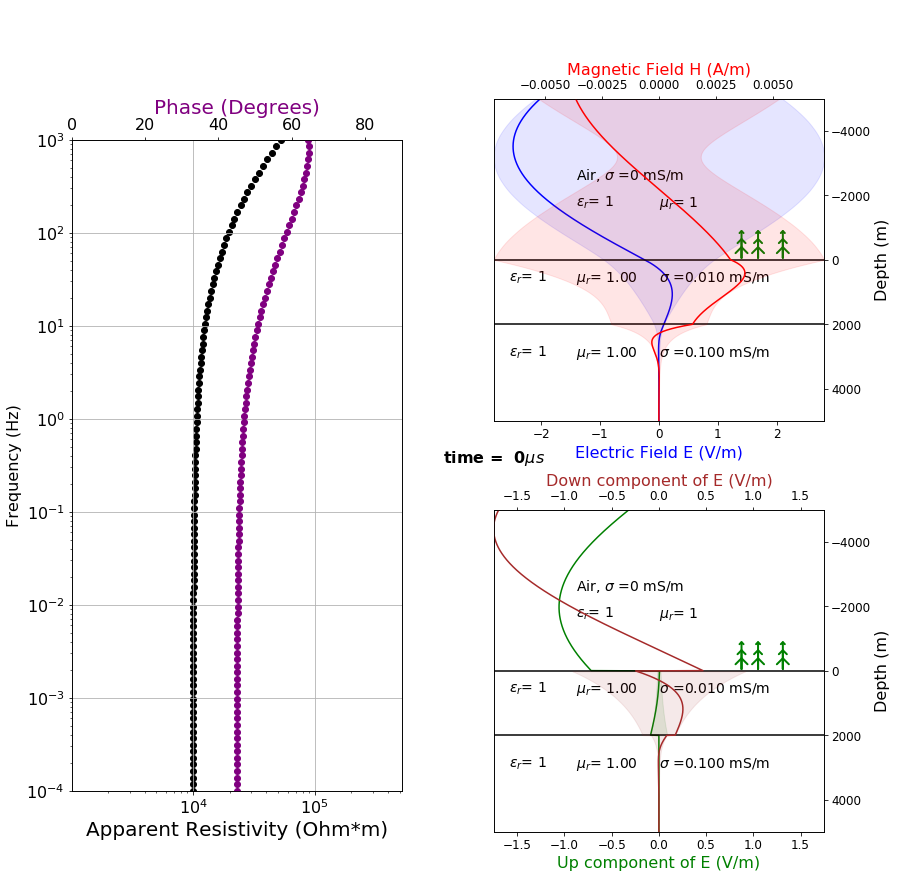

In [29]:
def visualiseE(ts, close=True):

    #Define the subplots and group associated fields
    #ax0: Electric Field ; ax1:Up component ; ax2:Apparent resistivity ; ax3:Magnetic field ; ax4:Down component; ax5 Phase
    fig = plt.figure(figsize=(15,15))
    ax0 = plt.subplot2grid((20,20), (0, 10),colspan=8,rowspan=8)
    ax1 = plt.subplot2grid((20,20), (10, 10),colspan=8,rowspan=8)
    ax2 = plt.subplot2grid((20,20), (1, 0), colspan=8,rowspan=16)
    
    #Link the axes scales
    ax3=ax0.twiny()
    ax4= ax1.twiny()
    ax5=ax2.twiny()

    #Plot Data
    ax2.scatter(Reskm,frangn,color='black')
    ax5.scatter(Phasekm,frangn,color='purple')

    #Set scale and legends for the data plot
    widthn=np.logspace(np.log10(Reskm.min())-1., np.log10(Reskm.max())+1., num=100, endpoint=True, base=10.0)
    frange1n=np.ones(100)*frange1
    ax2.plot(widthn,frange1n,linestyle='dashed',color='black')
    ax2.set_xscale('Log')
    ax2.set_yscale('Log')
    ax2.set_ylim([frangn.min(),frangn.max()])
    ax2.set_xlim([10.**(np.log10(Reskm.min())-1.),10.**(np.log10(Reskm.max())+1.)])
    ax2.set_xlabel('Apparent Resistivity (Ohm*m)',fontsize=20,color='black')
    ax2.set_ylabel('Frequency (Hz)',fontsize=16)
    ax2.grid(which='major')
    ax2.annotate(("%11.0f Hz")%(frange1),
            xy=(5*Reskm.max(),frange1), xycoords='data',
            xytext=(5*Reskm.max(),frange1), textcoords='data',
            fontsize=16., fontweight='bold')
    ax5.set_xlim([0.,90.])
    ax5.set_xlabel('Phase (Degrees)',fontsize=20,color='purple')

    #Initialize the fields plotting
    #Define updatable plots and theirs colors
    line0, =ax0.plot([],[],color='blue')
    line1, =ax3.plot([],[],color='red')
    line2, =ax1.plot([],[],color='green')
    line3, =ax4.plot([],[],color='brown')

    #Fill to show the maximum amplitude in time at different z
    ax0.fill_betweenx(z,np.squeeze(np.asarray(np.real(Exzt.min(axis=1)))),
                      np.squeeze(np.asarray(np.real(Exzt.max(axis=1)))), 
                      color='blue', alpha=0.1)

    ax3.fill_betweenx(z,np.squeeze(np.asarray(np.real(Hyzt.min(axis=1)))),
                      np.squeeze(np.asarray(np.real(Hyzt.max(axis=1)))), 
                      color='red', alpha=0.1)

    ax1.fill_betweenx(z,np.squeeze(np.asarray(np.real(Uz.min(axis=1)))),
                      np.squeeze(np.asarray(np.real(Uz.max(axis=1)))), 
                      color='green', alpha=0.1,where=(z>0.))

    ax4.fill_betweenx(z,np.squeeze(np.asarray(np.real(Dz.min(axis=1)))),
                     np.squeeze(np.asarray(np.real(Dz.max(axis=1)))), 
                     color='brown', alpha=0.1,where=(z>0.))
    
    #Set limits for x-axis
    ax0.set_xlim([np.real(Exzt).min(),np.real(Exzt).max()])
    ax3.set_xlim([np.real(Hyzt).min(),np.real(Hyzt).max()])
    ax1.set_xlim([np.real(Dz).min(),np.real(Dz).max()])
    ax4.set_xlim([np.real(Dz).min(),np.real(Dz).max()])

    #Plot the layered Earth and the physical properties
    PlotConfiguration(thickkm,sigkm,eps2,mu2,ax0,np.abs(Exzt.max()),z)
    PlotConfiguration(thickkm,sigkm,eps2,mu2,ax1,np.abs(Dz.max()),z)


    #change ticks size and numbers
    ax0.tick_params(labelsize=12)
    ax1.tick_params(labelsize=12)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=12)
    ax3.locator_params(axis='x',nbins=7)
    ax4.tick_params(labelsize=12)
    ax5.tick_params(labelsize=16)

    #Set labels
    ax0.set_xlabel('Electric Field E (V/m)',color='blue',fontsize=16)
    ax0.set_ylabel('Depth (m)',fontsize=16)
    ax1.set_xlabel('Up component of E (V/m)',color='green',fontsize=16)
    ax1.set_ylabel('Depth (m)',fontsize=16)
    ax3.set_xlabel('Magnetic Field H (A/m)',color='red',fontsize=16)
    ax4.set_xlabel('Down component of E (V/m)',color='brown',fontsize=16)

    #funtion to make a animated plot with the fields
        
    line0.set_data(np.real(Exzt[:,ts]),z)
    line1.set_data(np.real(Hyzt[:,ts]),z)
    line2.set_data(np.real(Uz[:,ts]),z)
    line3.set_data(np.real(Dz[:,ts]),z)
    ax0.set_title(("time =%3.0f$\mu s$")%(t[ts]*10**6), x=0., y=-0.15,fontsize=16.,fontweight="bold")

    if close:
        filename = 'movie_{}.png'.format(ts)
        fig.savefig(filename,dpi=72,bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)
        return imageio.imread(filename)
    else:
        plt.show()

visualiseE(0,close=False)

### Make Movies

In [17]:
# Make the GIF movie (will generate many image files in the current folder)
images = [visualiseE(i) for i in range(len(t))]
imageio.mimsave('movie.gif', images,fps=24)

---
### MT data at Yulong Mountain

MT data are acquired at four stations near Yulong Mountain. The impedance data are provided in the attached Excel files.
- Station 1: Foot of the mountain, imp01.xlsx
- Station 2: In the valley, imp02.xlsx
- Station 3: Highland near power lines and a tourism place, imp03.xlsx
- Station 4: On top of the mountain, imp04.xlsx

### Questions:
Choose one of the stations. Import the data and calculate the apparent resistivities and phase angles, and make the plots. 
1. What is the frequency range of the data?
2. What is the approximate range of the depth penetration?
3. Qualitatively comment on the 1D layered resistivity structure and the dimensionality at the site. 

### Your answers:
1. 
2. 
3. 


In [24]:
# Your plotting codes



---
## 5. Processing and Interpretation

In the following, we use forward modeling to recover the resistivity model that can best fit the observed data.

### Questions:
Now that you have the capability of simulating the MT responses on the surface for a 1D layered earth model, please fit the data of your choice by designing a multi-layered resistivity model. You are supposed to show:
1. The resistivity model that best fits the data
2. The observed field data
3. The simulated data from your recovered model

### Your answers:


In [25]:
# Your simulation and plotting codes



---
## 6. Synthesis

The single-station MT data have been preliminarily modelled and interpreted using 1D models. Try to answer the following questions.

### Questions:
1. What kind of geological information can you extract from the data and your recovered model?
2. Are there any restrictions or limitations in the data and the recovered model?
3. What are your suggestions for further improvements?

### Your answers:
1. 
2. 
3. 


---
## End of Worksheet